In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import math

from pykern import pkjson
from pykern.pkcollections import PKDict
import py.path

import Shadow
from Shadow.ShadowPreprocessorsXraylib import prerefl, pre_mlayer, bragg
from srxraylib.sources import srfunc
from sirepo.template import transfer_mat_bl

In [10]:
def calculate_stats(pos, oe):
    global alpha
    Tmat, x_prop_cen, xp_prop_cen, z_prop_cen, zp_prop_cen = transfer_mat_bl.tmat_calc(beam.duplicate(), epsilon)
    res = Tmat * sigma_mat * numpy.transpose(Tmat)
    pos += (oe.T_SOURCE if oe else 0)
    if oe:
        # oe.ALPHA is in radians after traceOE()
        alpha = int(alpha + 180 / math.pi * oe.ALPHA) % 360
    beam_stats.append(PKDict(
        isRotated=True if alpha == 90 or alpha == 270 else False,
        s=pos * 1e-2,
        x=x_prop_cen,
        xp=xp_prop_cen,
        z=z_prop_cen,
        zp=zp_prop_cen,
        matrix=Tmat.tolist(),
        sigma_mx=res.tolist(),
        sigmax=math.sqrt(res[0, 0]) * 1e-2,
        sigdix=math.sqrt(res[1, 1]),
        sigmaz=math.sqrt(res[2, 2]) * 1e-2,
        sigdiz=math.sqrt(res[3, 3]),
    ))
    return pos

In [11]:
def track_beamliine(pos, m1_cyl_angle):
    # initialize beam_stats to empty list
    global beam_stats
    beam_stats = []

    # drift, 28.5 m
    for j in range(1, 100):
        oe = Shadow.OE()
        oe.DUMMY = 1.0
        oe.set_empty(ALPHA=0)
        oe.FWRITE = 3
        oe.T_IMAGE = 0.0
        oe.T_SOURCE = 28.5
        beam.traceOE(oe, j)
        pos = calculate_stats(pos, oe)

    # mirror, M1
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.FMIRR = 2
    oe.ALPHA = 0
    oe.FHIT_C = 0
    oe.F_EXT = 0
    oe.F_DEFAULT = 0
    oe.SSOUR = 2900.0
    oe.SIMAG = 1000.0
    oe.THETA = 2.0002
    oe.F_CONVEX = 0
    oe.FCYL = 1
    oe.CIL_ANG = m1_cyl_angle
    oe.T_INCIDENCE = 2.0
    oe.T_REFLECTION = 2.0
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 28.5
    beam.traceOE(oe, 100)
    pos = calculate_stats(pos, oe)

    # drift, 1 m
    for j in range(101, 200):
        oe = Shadow.OE()
        oe.DUMMY = 1.0
        oe.set_empty(ALPHA=0)
        oe.FWRITE = 3
        oe.T_IMAGE = 0.0
        oe.T_SOURCE = 1.0
        beam.traceOE(oe, j)
        pos = calculate_stats(pos, oe)

    # mirror, M2
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.FMIRR = 2
    oe.ALPHA = 0
    oe.FHIT_C = 1
    oe.F_EXT = 0
    oe.F_DEFAULT = 0
    oe.SSOUR = 3000.0
    oe.SIMAG = 900.0
    oe.THETA = 2.0002
    oe.F_CONVEX = 0
    oe.FCYL = 1
    oe.CIL_ANG = 0.0
    oe.FSHAPE = 2
    oe.RWIDX2 = 15.0
    oe.RLEN2 = 25.0
    oe.F_MOVE = 1
    oe.OFFX = 1.0
    oe.T_INCIDENCE = 2.0
    oe.T_REFLECTION = 2.0
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 1.0
    beam.traceOE(oe, 200)
    pos = calculate_stats(pos, oe)

    # drift, 9.05 m
    for j in range(201, 300):
        oe = Shadow.OE()
        oe.DUMMY = 1.0
        oe.set_empty(ALPHA=0)
        oe.FWRITE = 3
        oe.T_IMAGE = 0.0
        oe.T_SOURCE = 9.050000000000182
        beam.traceOE(oe, j)
        pos = calculate_stats(pos, oe)

    # watch-point, 38.55 m
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.set_empty()
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 9.049999999981537
    beam.traceOE(oe, 300)
    pos = calculate_stats(pos, oe)

    # drift, 0.95 m
    for j in range(301, 401):
        oe = Shadow.OE()
        oe.DUMMY = 1.0
        oe.set_empty(ALPHA=0)
        oe.FWRITE = 3
        oe.T_IMAGE = 0.0
        oe.T_SOURCE = 0.9499999999998181
        beam.traceOE(oe, j)
        pos = calculate_stats(pos, oe)

    # watch-point, 39.5
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.set_empty()
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 1.864464138634503e-11
    beam.traceOE(oe, 401)
    pos = calculate_stats(pos, oe)

In [12]:
epsilon = 1e-06
ph_energy = 135.824
beam = transfer_mat_bl.create_mat_rays(epsilon, ph_energy)

# coupling is harder to see in a round beam
sigmax = 0.0045    * 2.0 # cm
sigdix = 29.13e-06 * 2.0 # urad
sigmaz = 0.0045          # cm
sigdiz = 29.13e-06       # urad

sigma_mat = numpy.matrix([
    [sigmax ** 2, 0, 0, 0],
    [0, sigdix ** 2, 0, 0],
    [0, 0, sigmaz ** 2, 0],
    [0, 0, 0, sigdiz ** 2],
])
alpha = 0

beam_stats = []
pos = calculate_stats(0, None)

track_beamliine(pos, 89.5) # 90 degrees <==> uncoupled

pkjson.dump_pretty(beam_stats, filename='beam_stats.json');

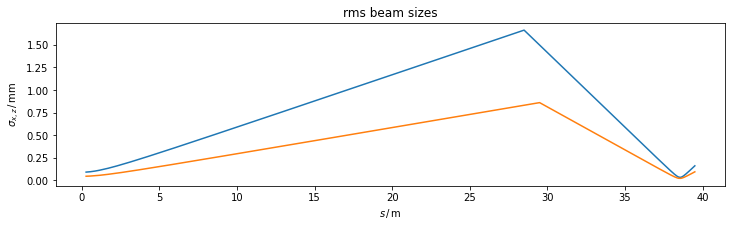

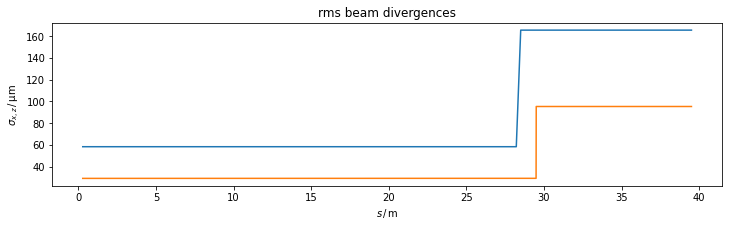

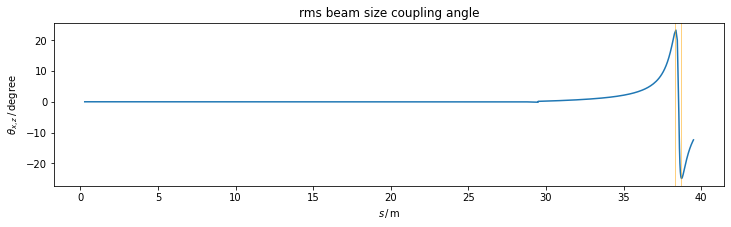

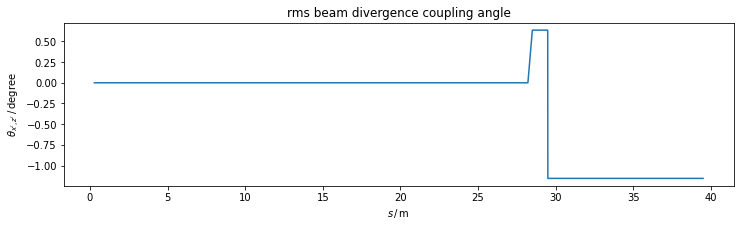

In [13]:
beam_stats = pkjson.load_any(py.path.local('beam_stats.json'))
degree = 180 / numpy.pi

sigmax = numpy.asarray([record.sigmax for record in beam_stats])
sigmaz = numpy.asarray([record.sigmaz for record in beam_stats])
sigdix = numpy.asarray([record.sigdix for record in beam_stats])
sigdiz = numpy.asarray([record.sigdiz for record in beam_stats])

x  = [record.s for record in beam_stats]
y1 = [record.sigmaz if record.isRotated else record.sigmax for record in beam_stats]
y2 = [record.sigmax if record.isRotated else record.sigmaz for record in beam_stats]

sigmaxz = numpy.asarray([record.sigma_mx[0][2] for record in beam_stats])
angxz   = (1/2) * numpy.arctan(2.e-4 * sigmaxz / (sigmax ** 2 - sigmaz ** 2))
sigmaxpzp = numpy.asarray([record.sigma_mx[1][3] for record in beam_stats])
angxpzp   = (1/2) * numpy.arctan(2 * sigmaxpzp / (sigdix ** 2 - sigdiz ** 2))

plt.figure(figsize=(12,3))
plt.title("rms beam sizes")
plt.xlabel(r'$s\,/\,\mathrm{m}$')
plt.ylabel(r'$\sigma_{x,z}\,/\,\mathrm{mm}$')
plt.plot(x, 1e3*sigmax, label=r'$\sigma_x$')
plt.plot(x, 1e3*sigmaz, label=r'$\sigma_z$')
plt.show()

plt.figure(figsize=(12,3))
plt.title("rms beam divergences")
plt.xlabel(r'$s\,/\,\mathrm{m}$')
plt.ylabel(r'$\sigma_{x,z}\,/\,\mathrm{\mu{m}}$')
plt.plot(x, 1.e6*sigdix, label=r'$\sigma_x$')
plt.plot(x, 1.e6*sigdiz, label=r'$\sigma_z$')
plt.show()

plt.figure(figsize=(12,3))
plt.title("rms beam size coupling angle")
plt.xlabel(r'$s\,/\,\mathrm{m}$')
plt.ylabel(r'$\theta_{x,z}\,/\,\mathrm{degree}$')
plt.plot(x, angxz * degree, label=r'$\theta_{x,z}$')
# plt.axhline(+24, c='g', lw=0.5)
# plt.axhline(-25, c='g', lw=0.5)
# plt.axhline(-12, c='g', lw=0.5)
# plt.axhline(+45, c='g', lw=0.5)
# plt.axhline(-45, c='g', lw=0.5)
plt.axvline(38.325, c='orange', lw=0.5)
plt.axvline(38.725, c='orange', lw=0.5)
plt.savefig("coupling_angles.pdf")
plt.savefig("coupling_angles.eps")
plt.show()

plt.figure(figsize=(12,3))
plt.title("rms beam divergence coupling angle")
plt.xlabel(r'$s\,/\,\mathrm{m}$')
plt.ylabel(r'$\theta_{x^\prime,z^\prime}\,/\,\mathrm{degree}$')
plt.plot(x, angxpzp * degree, label=r'$\theta_{x\prime,z\prime}$')
plt.show()

In [14]:
fmt = '[ ' + ', '.join(numpy.repeat('% 15.7e', 4)) +' ]'

print("Tmx at end")
tmx = beam_stats[-1].matrix
for ir in range(4):
    print(fmt % tuple(tmx[ir]))

print("\nΣmx at end")
sig = beam_stats[-1].sigma_mx
for ir in range(4):
    print(fmt % tuple(sig[ir]))

Tmx at end
[  -4.7919773e-01,  -2.6571354e+02,   1.2916631e-02,   3.6812397e+01 ]
[  -1.3447252e-03,  -2.8324669e+00,   1.1742392e-05,   3.3465818e-02 ]
[   1.1220507e-02,   3.1978651e+01,  -4.4454223e-01,  -3.1138981e+02 ]
[   1.0046276e-05,   2.8632248e-02,  -1.4445320e-03,  -3.2613604e+00 ]

Σmx at end
[   2.5939835e-04,   2.6078239e-06,  -3.9120108e-05,  -1.2846744e-07 ]
[   2.6078239e-06,   2.7378866e-08,  -3.1761455e-07,  -3.6932422e-10 ]
[  -3.9120108e-05,  -3.1761455e-07,   8.9762153e-05,   8.7787628e-07 ]
[  -1.2846744e-07,  -3.6932422e-10,   8.7787628e-07,   9.0706971e-09 ]
